<a href="https://colab.research.google.com/github/ShabnaIlmi/Data-Science-Group-Project/blob/End_User_Risk_Prediction/EndUser_Test_Random_Forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Classification Report:
               precision    recall  f1-score   support

   High Risk       0.99      0.99      0.99       382
    Low Risk       0.92      1.00      0.96        23
 Medium Risk       0.86      0.82      0.84        22

    accuracy                           0.98       427
   macro avg       0.92      0.94      0.93       427
weighted avg       0.98      0.98      0.98       427

Accuracy: 0.98


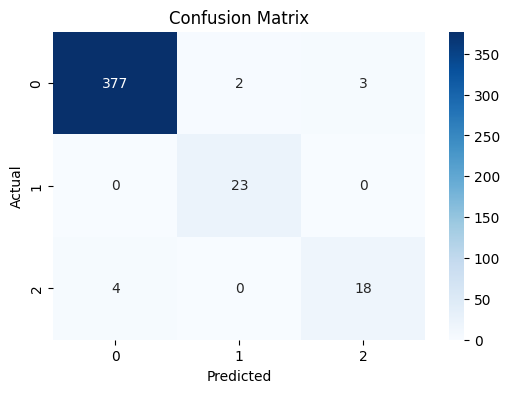

Predicted Risk Level for Lanka Walltile PLC : Low Risk


In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 1 Load Dataset
file_path = "/content/drive/MyDrive/DSGP_User/Pre Processed data/Stock-report_with_risk.xlsx"
data = pd.read_excel(file_path)

# 2 Strip column names to avoid hidden spaces
data.columns = data.columns.str.strip()

# 3 Define Target Variable
target_col = "Risk Level"

# 4 Identify categorical and numerical columns
categorical_cols = ['Customer name', 'Product code', 'Invoice No', 'UOM', 'Warehouse']
numerical_cols = ['Issued Qty', 'Transaction Date']

# 5 Convert Transaction Date to numeric (days since epoch)
data['Transaction Date'] = pd.to_datetime(data['Transaction Date'], errors='coerce')
data['Transaction Date'] = data['Transaction Date'].astype(int) / 10**9

# 6 Handle categorical variables using Label Encoding
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le  # Store the encoder for later use in prediction

# 7 Fill missing values in numerical columns
data[numerical_cols] = data[numerical_cols].fillna(0)

# 8 Define Features (X) and Target (y)
X = data.drop(columns=[target_col])
y = data[target_col]

# 9 Train-Test Split (80-20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 10 Feature Scaling
scaler = StandardScaler()
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

# 11 Train Random Forest Model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# 12 Model Evaluation
y_pred = rf_model.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")

# 13 Confusion Matrix Visualization
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# 14 Prediction Function
def predict_risk_level(customer_name, issued_qty, transaction_date, product_code):
    """
    Predicts the risk level for a given customer based on provided data.
    """
    # Create DataFrame for input data
    input_data = pd.DataFrame({
        'Customer name': [customer_name],
        'Issued Qty': [issued_qty],
        'Transaction Date': [transaction_date],
        'Product code': [product_code]
    })

    # Strip column names
    input_data.columns = input_data.columns.str.strip()

    # Convert Transaction Date to numeric
    input_data['Transaction Date'] = pd.to_datetime(input_data['Transaction Date'], errors='coerce')
    input_data['Transaction Date'] = input_data['Transaction Date'].astype(int) / 10**9

    # Encode categorical variables using trained label encoders
    for col in categorical_cols:
        if col in input_data.columns:
            if input_data[col][0] in label_encoders[col].classes_:
                input_data[col] = label_encoders[col].transform(input_data[col])
            else:
                print(f"Warning: Unseen category '{input_data[col][0]}' in '{col}'. Assigning default category 0.")
                input_data[col] = 0  # Assign unseen categories a default value

    # Fill missing numerical values
    input_data[numerical_cols] = input_data[numerical_cols].fillna(0)

    # Ensure all expected columns are present, adding missing ones as 0
    for col in X_train.columns:
        if col not in input_data.columns:
            input_data[col] = 0  # Fill missing columns with 0

    # Ensure correct feature order
    input_data = input_data[X_train.columns]

    # Scale numerical features
    input_data[numerical_cols] = scaler.transform(input_data[numerical_cols])

    # Make the prediction
    predicted_risk = rf_model.predict(input_data)[0]

    return predicted_risk


# 15 Example Usage (Pre-defined Input)
customer_name = "Lanka Walltile PLC "  # Replace with  customer name
issued_qty = 100  #  quantity
transaction_date = "2025-03-30"  # Transaction date
product_code = "Ammonia"  # Replace with product code

# Predict risk level
predicted_risk = predict_risk_level(customer_name, issued_qty, transaction_date, product_code)

# Print the result
print(f"Predicted Risk Level for {customer_name}: {predicted_risk}")



In [ ]:
import joblib
import pandas as pd
import numpy as np
from datetime import datetime

# Load saved model and preprocessing objects
rf_model = joblib.load("/content/drive/MyDrive/DSGP_User/Pre Processed data/random_forest_model.pkl")
label_encoders = joblib.load("/content/drive/MyDrive/DSGP_User/Pre Processed data/Label_Encoder.pkl")


# Define categorical and numerical columns (must match the ones used during training)
categorical_cols = ['Customer name', 'Product code', 'Invoice No', 'UOM', 'Warehouse']
numerical_cols = ['Issued Qty', 'Transaction Date']

# 14 Prediction Function
def predict_risk_level(customer_name, issued_qty, transaction_date, product_code):
    """
    Predicts the risk level for a given customer based on provided data.
    """
    # Create a DataFrame for input data with all columns used during training
    input_data = pd.DataFrame({
        'Customer name': [customer_name],
        'Issued Qty': [issued_qty],
        'Transaction Date': [transaction_date],
        'Product code': [product_code],
        'Invoice No': [0],  # Add missing columns with default values
        'UOM': [0],
        'Warehouse': [0]
    })

    # Strip column names
    input_data.columns = input_data.columns.str.strip()

    # Convert Transaction Date to numeric
    input_data['Transaction Date'] = pd.to_datetime(input_data['Transaction Date'], errors='coerce')
    input_data['Transaction Date'] = input_data['Transaction Date'].astype(int) / 10**9

    # Encode categorical variables using trained label encoders
    for col in categorical_cols:
        if col in input_data.columns:
            if input_data[col][0] in label_encoders[col].classes_:
                input_data[col] = label_encoders[col].transform(input_data[col])
            else:
                print(f"Warning: Unseen category '{input_data[col][0]}' in '{col}'. Assigning default category 0.")
                input_data[col] = 0  # Assign unseen categories a default value

    # Fill missing numerical values
    input_data[numerical_cols] = input_data[numerical_cols].fillna(0)

    # Ensure all expected columns are present, adding missing ones as 0
    for col in rf_model.feature_names_in_:
        if col not in input_data.columns:
            input_data[col] = 0  # Fill missing columns with 0

    # Ensure correct feature order (same as during training)
    input_data = input_data[rf_model.feature_names_in_]

    # Make the prediction (no scaling required)
    predicted_risk = rf_model.predict(input_data)[0]

    return predicted_risk


# 15 Example Usage (Pre-defined Input)
customer_name = "SN PRODUCTS"  # Replace with customer name
issued_qty = 2022  # Replace with quantity
transaction_date = "2024-12-12"  # Replace with transaction date
product_code = "Potassium Permanganate"  # Replace with product code

# Predict risk level
predicted_risk = predict_risk_level(customer_name, issued_qty, transaction_date, product_code)

# Print the result
print(f"Predicted Risk Level for {customer_name}: {predicted_risk}")


Predicted Risk Level for SN PRODUCTS: 0


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Classification Report:
               precision    recall  f1-score   support

   High Risk       0.00      0.00      0.00         8
    Low Risk       0.99      0.98      0.98       224
 Medium Risk       0.92      1.00      0.96        89
     No Risk       0.43      0.50      0.46         6

    accuracy                           0.95       327
   macro avg       0.58      0.62      0.60       327
weighted avg       0.93      0.95      0.94       327

Accuracy: 0.95


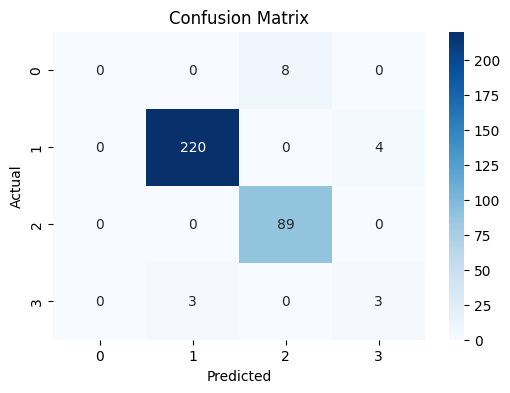


🔹 Predicted Risk Level for Ansell Lanka: Low Risk

🚨 No transactions found in the past 3 months for this customer.


In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import datetime

# 1️⃣ Load Dataset
file_path = "/content/drive/MyDrive/DSGP_User/Pre Processed data/Stock-report_with_risk.xlsx"
data = pd.read_excel(file_path)

# 2️⃣ Strip column names to avoid hidden spaces
data.columns = data.columns.str.strip()

# 3️⃣ Define Target Variable
target_col = "Risk Level"

# 4️⃣ Identify categorical and numerical columns
categorical_cols = ['Customer name', 'Product code', 'Invoice No', 'UOM', 'Warehouse']
numerical_cols = ['Issued Qty', 'Transaction Date']

# 5️⃣ Convert Transaction Date to numeric (days since epoch)
#data['Transaction Date'] = pd.to_datetime(data['Transaction Date'], errors='coerce')
# 5️⃣ Convert Transaction Date to numeric (days since epoch)
data['Transaction Date'] = pd.to_datetime(data['Transaction Date'], errors='coerce')
# Convert to Unix timestamp (seconds since epoch)
data['Transaction Date'] = data['Transaction Date'].apply(lambda x: x.timestamp() if pd.notna(x) else 0)

# 6️⃣ Handle categorical variables using Label Encoding
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le  # Store the encoder for later use in prediction

# 7️⃣ Fill missing values in numerical columns
data[numerical_cols] = data[numerical_cols].fillna(0)

# 8️⃣ Define Features (X) and Target (y)
X = data.drop(columns=[target_col])
y = data[target_col]

# 9️⃣ Train-Test Split (80-20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 🔟 Feature Scaling
scaler = StandardScaler()
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

# 1️⃣1️⃣ Train Random Forest Model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# 1️⃣2️⃣ Model Evaluation
y_pred = rf_model.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")

# 1️⃣3️⃣ Confusion Matrix Visualization
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# 1️⃣4️⃣ Prediction Function
def predict_risk_level(customer_name, issued_qty, transaction_date, product_code):
    """
    Predicts the risk level for a given customer based on provided data.
    Also retrieves past 3 months of transactions.
    """

    # Convert Transaction Date to datetime
    transaction_date = pd.to_datetime(transaction_date, errors='coerce')

    # 1️⃣ Create DataFrame for input data
    input_data = pd.DataFrame({
        'Customer name': [customer_name],
        'Issued Qty': [issued_qty],
        'Transaction Date': [transaction_date],
        'Product code': [product_code]
    })

    # 2️⃣ Strip column names
    input_data.columns = input_data.columns.str.strip()

    # 3️⃣ Convert Transaction Date to numeric
    input_data['Transaction Date'] = input_data['Transaction Date'].astype(int) / 10**9

    # 4️⃣ Encode categorical variables using trained label encoders
    for col in categorical_cols:
        if col in input_data.columns:
            if input_data[col][0] in label_encoders[col].classes_:
                input_data[col] = label_encoders[col].transform(input_data[col])
            else:
                print(f"Warning: Unseen category '{input_data[col][0]}' in '{col}'. Assigning default category 0.")
                input_data[col] = 0  # Assign unseen categories a default value

    # 5️⃣ Fill missing numerical values
    input_data[numerical_cols] = input_data[numerical_cols].fillna(0)

    # 6️⃣ Ensure all expected columns are present, adding missing ones as 0
    for col in X_train.columns:
        if col not in input_data.columns:
            input_data[col] = 0  # Fill missing columns with 0

    # 7️⃣ Ensure correct feature order
    input_data = input_data[X_train.columns]

    # 8️⃣ Scale numerical features
    input_data[numerical_cols] = scaler.transform(input_data[numerical_cols])

    # 9️⃣ Make the prediction
    predicted_risk = rf_model.predict(input_data)[0]

    # 1️⃣0️⃣ Retrieve past 3 months transactions for the given customer
    #three_months_ago = transaction_date - pd.DateOffset(months=3)
    # Convert three_months_ago to Unix timestamp for comparison
    #three_months_ago_timestamp = three_months_ago.timestamp()
    #recent_transactions = data[(data['Customer name'] == customer_name) & (data['Transaction Date'] >= three_months_ago_timestamp)]

    # 1️⃣0️⃣ Retrieve past 3 months transactions using a fixed reference date (2025-01-01)
    reference_date = pd.to_datetime("2024-10-01")
    three_months_ago = reference_date - pd.DateOffset(months=3)
    three_months_ago_timestamp = three_months_ago.timestamp()  # Convert to Unix timestamp

    recent_transactions = data[
        (data['Customer name'] == customer_name) &
        (data['Transaction Date'] >= three_months_ago_timestamp)
    ]

    return predicted_risk, recent_transactions


# 1️⃣5️⃣ Example Usage (Predefined Inputs)
customer_name = "Ansell Lanka"  # Predefined customer name
issued_qty = 900  # Predefined quantity
transaction_date = "2024-09-10"  # Predefined transaction date
product_code = "LC-IG-ISGEC-INDIA"  # Predefined product code

# Predict risk level and get recent transactions
predicted_risk, past_transactions = predict_risk_level(customer_name, issued_qty, transaction_date, product_code)

# Print the risk level
print(f"\n🔹 Predicted Risk Level for {customer_name}: {predicted_risk}")

# Print past transactions (if any)
if not past_transactions.empty:
    print("\n📌 Past 3 Months Transactions:")
    print(past_transactions[['Transaction Date', 'Invoice No', 'Issued Qty', 'Product code', 'Warehouse']])
else:
    print("\n🚨 No transactions found in the past 3 months for this customer.")


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Classification Report:
               precision    recall  f1-score   support

   High Risk       0.00      0.00      0.00         8
    Low Risk       0.99      0.98      0.98       224
 Medium Risk       0.92      1.00      0.96        89
     No Risk       0.43      0.50      0.46         6

    accuracy                           0.95       327
   macro avg       0.58      0.62      0.60       327
weighted avg       0.93      0.95      0.94       327

Accuracy: 0.95


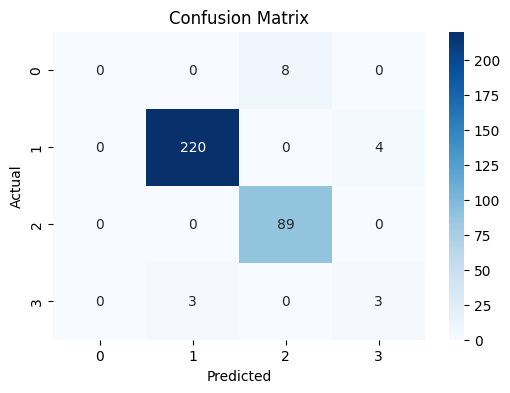


🔹 Predicted Risk Level for Ansell Lanka: Low Risk

🚨 No past transactions found for this customer.


In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 1️⃣ Load Dataset
file_path = "/content/drive/MyDrive/DSGP_User/Pre Processed data/Stock-report_with_risk.xlsx"
data = pd.read_excel(file_path)

# 2️⃣ Strip column names to avoid hidden spaces
data.columns = data.columns.str.strip()

# 3️⃣ Define Target Variable
target_col = "Risk Level"

# 4️⃣ Identify categorical and numerical columns
categorical_cols = ['Customer name', 'Product code', 'Invoice No', 'UOM', 'Warehouse']
numerical_cols = ['Issued Qty', 'Transaction Date']

# 5️⃣ Convert Transaction Date to datetime format and then to Unix timestamp (numeric)
data['Transaction Date'] = pd.to_datetime(data['Transaction Date'], errors='coerce')
data['Transaction Date'] = data['Transaction Date'].apply(lambda x: x.timestamp() if pd.notna(x) else 0)  # Convert to numeric

# 6️⃣ Handle categorical variables using Label Encoding
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le  # Store the encoder for later use in prediction

# 7️⃣ Fill missing values in numerical columns
data[numerical_cols] = data[numerical_cols].fillna(0)

# 8️⃣ Define Features (X) and Target (y)
X = data.drop(columns=[target_col])
y = data[target_col]

# 9️⃣ Train-Test Split (80-20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 🔟 Feature Scaling
scaler = StandardScaler()
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

# 1️⃣1️⃣ Train Random Forest Model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# 1️⃣2️⃣ Model Evaluation
y_pred = rf_model.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")

# 1️⃣3️⃣ Confusion Matrix Visualization
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# 1️⃣4️⃣ Prediction Function
def predict_risk_level(customer_name, issued_qty, transaction_date, product_code):
    """
    Predicts the risk level for a given customer based on provided data.
    Also retrieves and displays all past transactions of the customer.
    """

    # Convert Transaction Date to datetime
    transaction_date = pd.to_datetime(transaction_date, errors='coerce')

    # 1️⃣ Create DataFrame for input data
    input_data = pd.DataFrame({
        'Customer name': [customer_name],
        'Issued Qty': [issued_qty],
        'Transaction Date': [transaction_date],
        'Product code': [product_code]
    })

    # 2️⃣ Strip column names
    input_data.columns = input_data.columns.str.strip()

    # 3️⃣ Convert Transaction Date to numeric (Unix timestamp)
    input_data['Transaction Date'] = input_data['Transaction Date'].astype(int) / 10**9

    # 4️⃣ Encode categorical variables using trained label encoders
    for col in categorical_cols:
        if col in input_data.columns:
            if input_data[col][0] in label_encoders[col].classes_:
                input_data[col] = label_encoders[col].transform(input_data[col])
            else:
                print(f"Warning: Unseen category '{input_data[col][0]}' in '{col}'. Assigning default category 0.")
                input_data[col] = 0  # Assign unseen categories a default value

    # 5️⃣ Fill missing numerical values
    input_data[numerical_cols] = input_data[numerical_cols].fillna(0)

    # 6️⃣ Ensure all expected columns are present, adding missing ones as 0
    for col in X_train.columns:
        if col not in input_data.columns:
            input_data[col] = 0  # Fill missing columns with 0

    # 7️⃣ Ensure correct feature order
    input_data = input_data[X_train.columns]

    # 8️⃣ Scale numerical features
    input_data[numerical_cols] = scaler.transform(input_data[numerical_cols])

    # 9️⃣ Make the prediction
    predicted_risk = rf_model.predict(input_data)[0]

    # 1️⃣0️⃣ Retrieve **all past transactions** for the given customer
    past_transactions = data[data['Customer name'] == customer_name].sort_values(by='Transaction Date', ascending=True)

    return predicted_risk, past_transactions


# 1️⃣5️⃣ Example Usage (Predefined Inputs)
customer_name = "Ansell Lanka"  # Predefined customer name
issued_qty = 900 # Predefined quantity
transaction_date = "2024-09-10"  # Predefined transaction date
product_code = "LC-IG-ISGEC-INDIA"  # Predefined product code

# Predict risk level and get all past transactions
predicted_risk, past_transactions = predict_risk_level(customer_name, issued_qty, transaction_date, product_code)

# Print the risk level
print(f"\n🔹 Predicted Risk Level for {customer_name}: {predicted_risk}")

# Print all past transactions (if any)
if not past_transactions.empty:
    print("\n📌 All Past Transactions:")
    print(past_transactions[['Transaction Date', 'Invoice No', 'Issued Qty', 'Product code', 'Warehouse']])
else:
    print("\n🚨 No past transactions found for this customer.")
